In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize baseline results into Pandas DataFrame

In [2]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [13]:
model_meta = pd.DataFrame()

source_train_baseline_dir = '../baseline/baseline_s_20k_t_20-2021-09-19-0759'
exp_dir = '.'

for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet'):
        trial_results = summarize(source_train_baseline_dir, f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx
        trial_results.loc[:, 'num_topmost'] = 0

        try:
            with open(os.path.join(source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in os.listdir(exp_dir):
    if os.path.isdir(d):
        for f in os.listdir(d):
            if f.endswith('.parquet'):
                trial_results = summarize(d, f)
                num_topmost = 2 if re.split('[_]', d)[2] == '2topmost' else 1
                phase, _, iter_idx, _ = re.split('[_.]', f)
                trial_results.loc[:, 'phase'] = phase
                trial_results.loc[:, 'iter_idx'] = iter_idx
                trial_results.loc[:, 'num_topmost'] = num_topmost

                try:
                    with open(os.path.join(d, f'args_{iter_idx}.json')) as arg_f:
                        args = json.load(arg_f)
                except OSError:
                    print('No corresponding args.json file associated with trial!')

                for key in ['num_source_epochs', 'num_target_epochs', 'lr', 'source_batch_size', 'target_batch_size',
                            'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                    trial_results.loc[:, key] = args[key]

                model_meta = model_meta.append(trial_results, ignore_index=True)
        

In [14]:
model_meta.columns

Index(['train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'train_auc',
       'valid_auc', 'best_valid_acc', 'mimic_test_loss', 'mimic_test_acc',
       'mimic_test_auc', 'chexpert_test_loss', 'chexpert_test_acc',
       'chexpert_test_auc', 'epochs', 'final_train_loss', 'best_valid_loss',
       'phase', 'iter_idx', 'num_topmost', 'num_source_epochs',
       'num_target_epochs', 'lr', 'source_batch_size', 'target_batch_size',
       'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples',
       'n_target_samples'],
      dtype='object')

# Summarize performance for fine-tuning topmost 2 layers

In [29]:
topmost2_meta = model_meta[(model_meta['phase'] == 'target') & (model_meta['num_topmost'] == 2)]

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [30]:
topmost2_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

mimic_test_loss  mimic_test_acc  mimic_test_auc  \
n_target_samples                                                    
20                       0.670254        0.663449        0.709883   
50                       0.688417        0.664452        0.708212   
100                      0.692195        0.669215        0.708513   
200                      0.695144        0.670594        0.711793   
500                      0.678657        0.670970        0.712976   
1000                     0.698755        0.655177        0.723416   

                  chexpert_test_loss  chexpert_test_acc  chexpert_test_auc  
n_target_samples                                                            
20                          0.610453           0.816750           0.868849  
50                          0.627612           0.816375           0.868962  
100                         0.637615           0.816750           0.867425  
200                         0.643059           0.817000           0.871606  
500                         0.612115           0.816375           0.871887  
1000                        0.648855           0.804250           0.880149

In [31]:
topmost2_meta.groupby('n_target_samples').mean()[performance_cols]

mimic_test_loss  mimic_test_acc  mimic_test_auc  \
n_target_samples                                                    
20                       0.665223        0.645275        0.684291   
50                       0.675230        0.639550        0.677377   
100                      0.675673        0.643227        0.678542   
200                      0.676448        0.642141        0.675635   
500                      0.665839        0.646695        0.690456   
1000                     0.671378        0.638422        0.682846   

                  chexpert_test_loss  chexpert_test_acc  chexpert_test_auc  
n_target_samples                                                            
20                          0.605293           0.802750           0.845318  
50                          0.612525           0.794042           0.837542  
100                         0.614700           0.791500           0.837784  
200                         0.616193           0.788708           0.834340  
500                         0.602358           0.800875           0.859943  
1000                        0.614065           0.783250           0.841667

In [32]:
topmost2_meta.groupby('n_target_samples').std()[performance_cols]

mimic_test_loss  mimic_test_acc  mimic_test_auc  \
n_target_samples                                                    
20                       0.007721        0.018902        0.027592   
50                       0.013196        0.025330        0.033608   
100                      0.015161        0.028386        0.035456   
200                      0.018370        0.029234        0.039369   
500                      0.011235        0.026182        0.030771   
1000                     0.025146        0.023799        0.047564   

                  chexpert_test_loss  chexpert_test_acc  chexpert_test_auc  
n_target_samples                                                            
20                          0.007134           0.012189           0.020554  
50                          0.015602           0.021127           0.027651  
100                         0.020563           0.028164           0.028865  
200                         0.024695           0.031353           0.036526  
500                         0.009253           0.013611           0.011688  
1000                        0.030881           0.030915           0.042638

In [34]:
mimic_meta = topmost2_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc'])
chex_meta = topmost2_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc'])

Text(0.5, 1.0, 'Chexpert test performance')

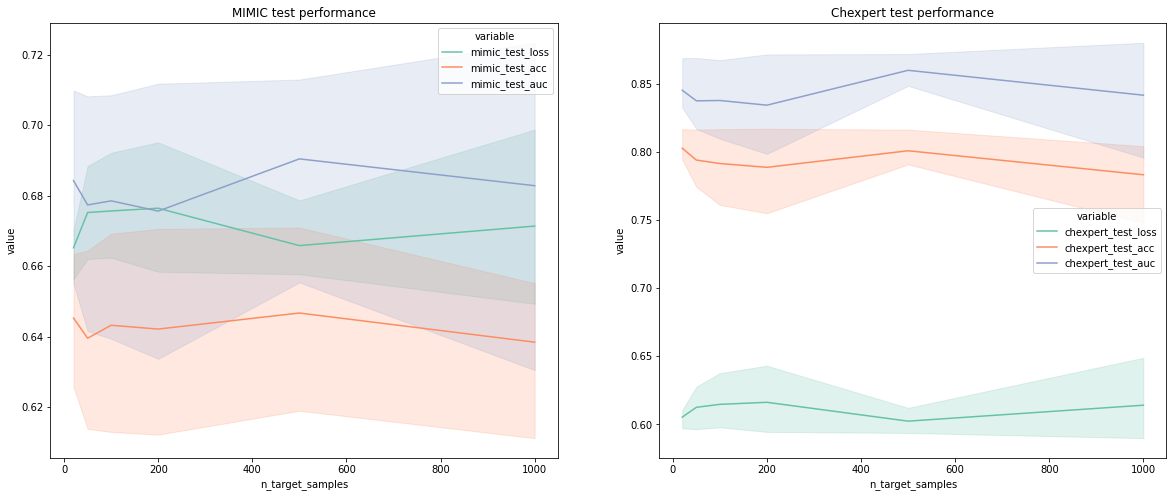

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')

# Summarize performance for fine-tuning topmost 1 layer

In [36]:
topmost1_meta = model_meta[(model_meta['phase'] == 'target') & (model_meta['num_topmost'] == 1)]

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [37]:
topmost1_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

mimic_test_loss  mimic_test_acc  mimic_test_auc  \
n_target_samples                                                    
20                       0.670253        0.663575        0.709865   
50                       0.688758        0.666332        0.709444   
100                      0.699006        0.670218        0.714609   
200                      0.687645        0.665455        0.721506   
500                      0.699618        0.668839        0.720208   
1000                     0.689238        0.666207        0.709495   

                  chexpert_test_loss  chexpert_test_acc  chexpert_test_auc  
n_target_samples                                                            
20                          0.610453           0.816125           0.868784  
50                          0.631038           0.816625           0.869656  
100                         0.651613           0.815500           0.874325  
200                         0.631934           0.814875           0.880074  
500                         0.650055           0.813000           0.880382  
1000                        0.629771           0.815000           0.869853

In [38]:
topmost1_meta.groupby('n_target_samples').mean()[performance_cols]

mimic_test_loss  mimic_test_acc  mimic_test_auc  \
n_target_samples                                                    
20                       0.665239        0.645275        0.684285   
50                       0.675077        0.640302        0.677331   
100                      0.678340        0.641472        0.675678   
200                      0.672899        0.642392        0.682476   
500                      0.677550        0.642266        0.684750   
1000                     0.672156        0.643854        0.690704   

                  chexpert_test_loss  chexpert_test_acc  chexpert_test_auc  
n_target_samples                                                            
20                          0.605322           0.802542           0.845296  
50                          0.613554           0.792875           0.836491  
100                         0.619985           0.783042           0.831877  
200                         0.611498           0.792583           0.842905  
500                         0.618480           0.784083           0.846327  
1000                        0.611711           0.795125           0.860648

In [39]:
topmost1_meta.groupby('n_target_samples').std()[performance_cols]

mimic_test_loss  mimic_test_acc  mimic_test_auc  \
n_target_samples                                                    
20                       0.007692        0.018958        0.027583   
50                       0.013825        0.025947        0.034800   
100                      0.019923        0.030386        0.043585   
200                      0.016454        0.023715        0.039576   
500                      0.020627        0.028714        0.048441   
1000                     0.014862        0.027739        0.029999   

                  chexpert_test_loss  chexpert_test_acc  chexpert_test_auc  
n_target_samples                                                            
20                          0.007082           0.011830           0.020516  
50                          0.017527           0.022981           0.029484  
100                         0.028799           0.037494           0.043051  
200                         0.020277           0.023033           0.034401  
500                         0.028530           0.034172           0.044676  
1000                        0.016313           0.022148           0.008704

In [40]:
mimic_meta = topmost1_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc'])
chex_meta = topmost1_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc'])

Text(0.5, 1.0, 'Chexpert test performance')

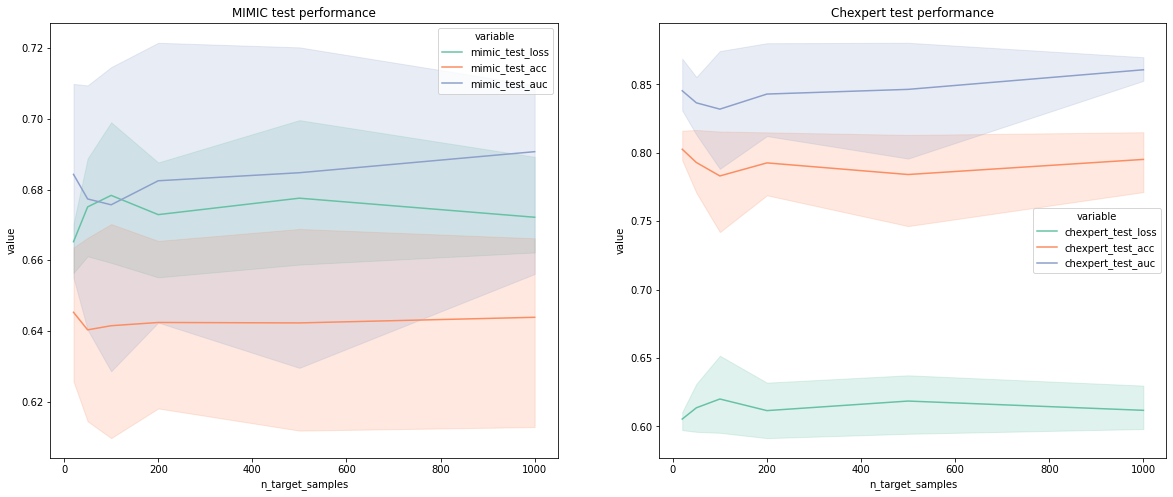

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')

# Visualize training and validation losses for the two training phases

In [48]:
def plot_losses(df, num_topmost=1, n_target_samples=20, loss_type='train', ax=None):
   
    df = df[(df['num_topmost'] == num_topmost) & (df['n_target_samples'] == n_target_samples)].copy()
    subset_df = df[df['phase'] == 'target'].copy()
    key = f'{loss_type}_loss'
    losses = np.stack(subset_df.loc[:, key].values)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss with fine-tuning topmost {num_topmost} linear layers'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

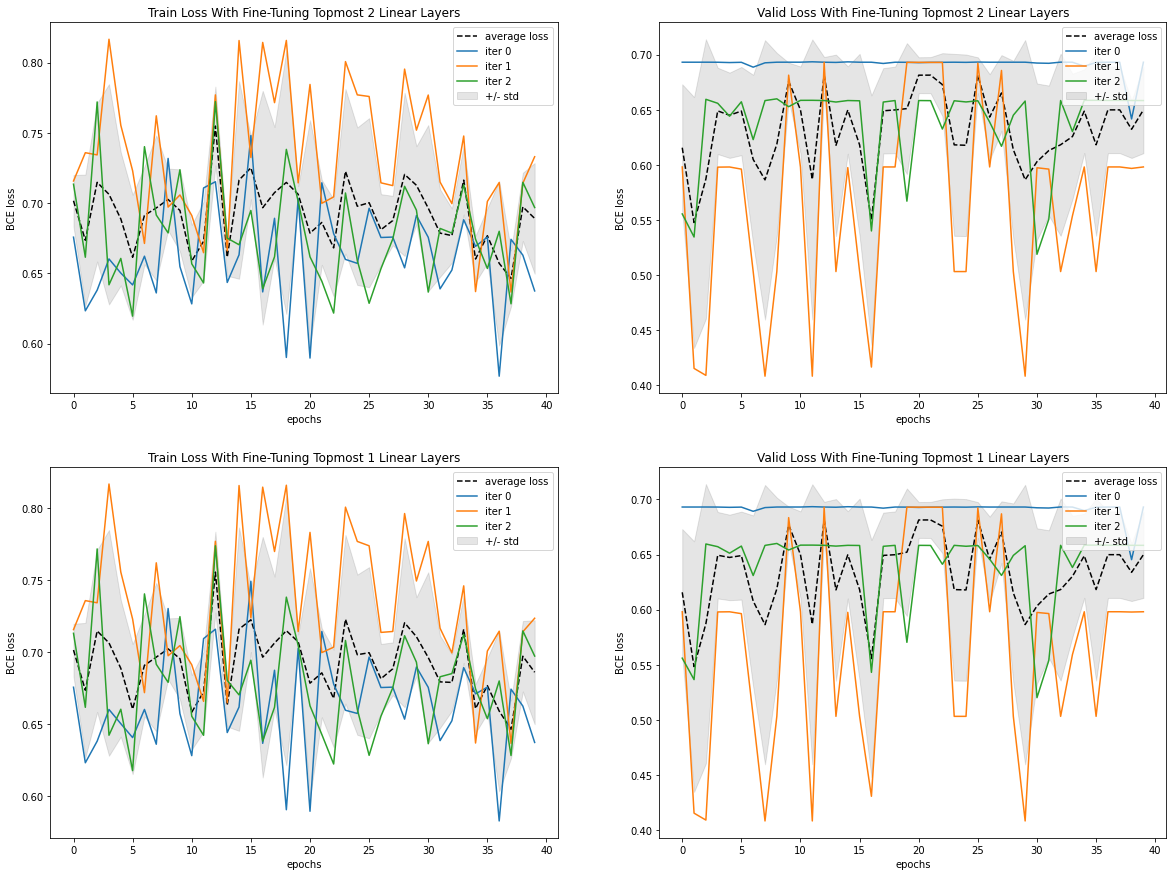

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 2, n_target_samples, loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 2, n_target_samples, loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 1, n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 1, n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

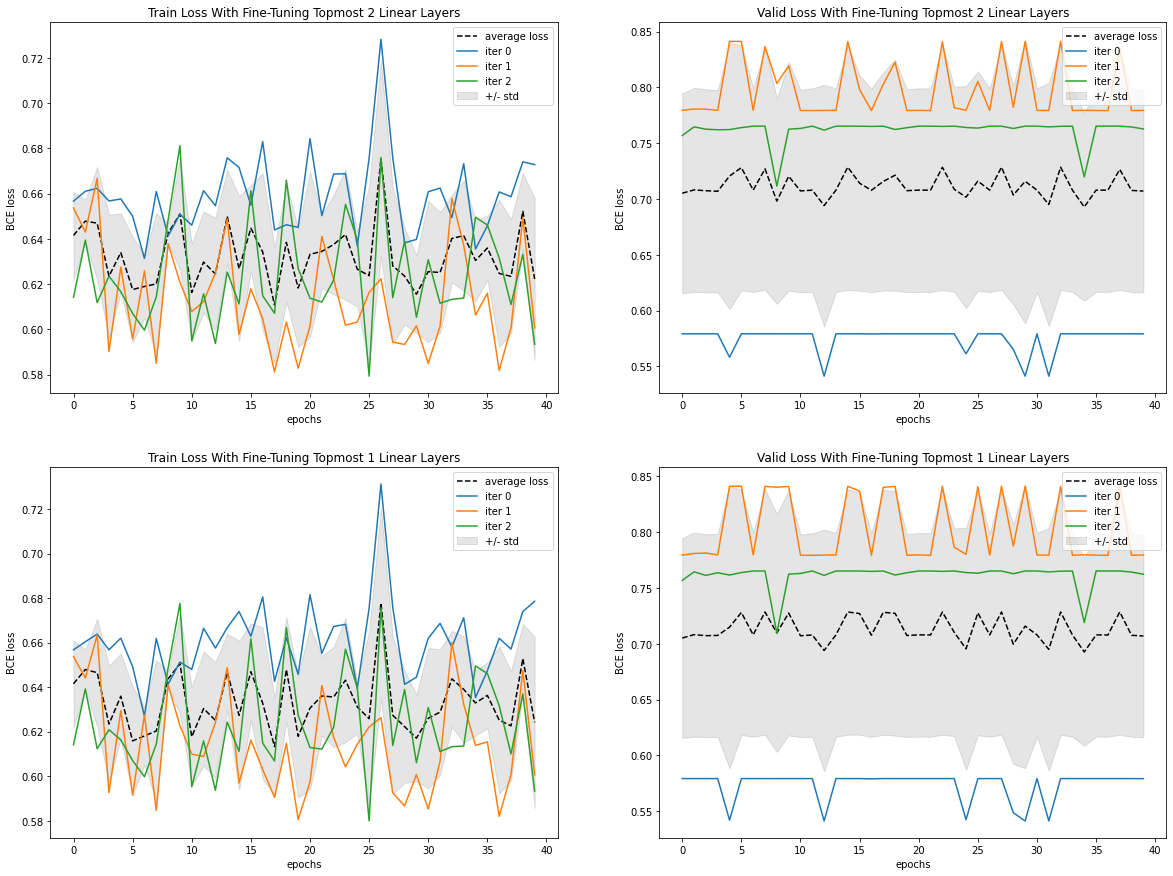

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 2, n_target_samples, loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 2, n_target_samples, loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 1, n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 1, n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

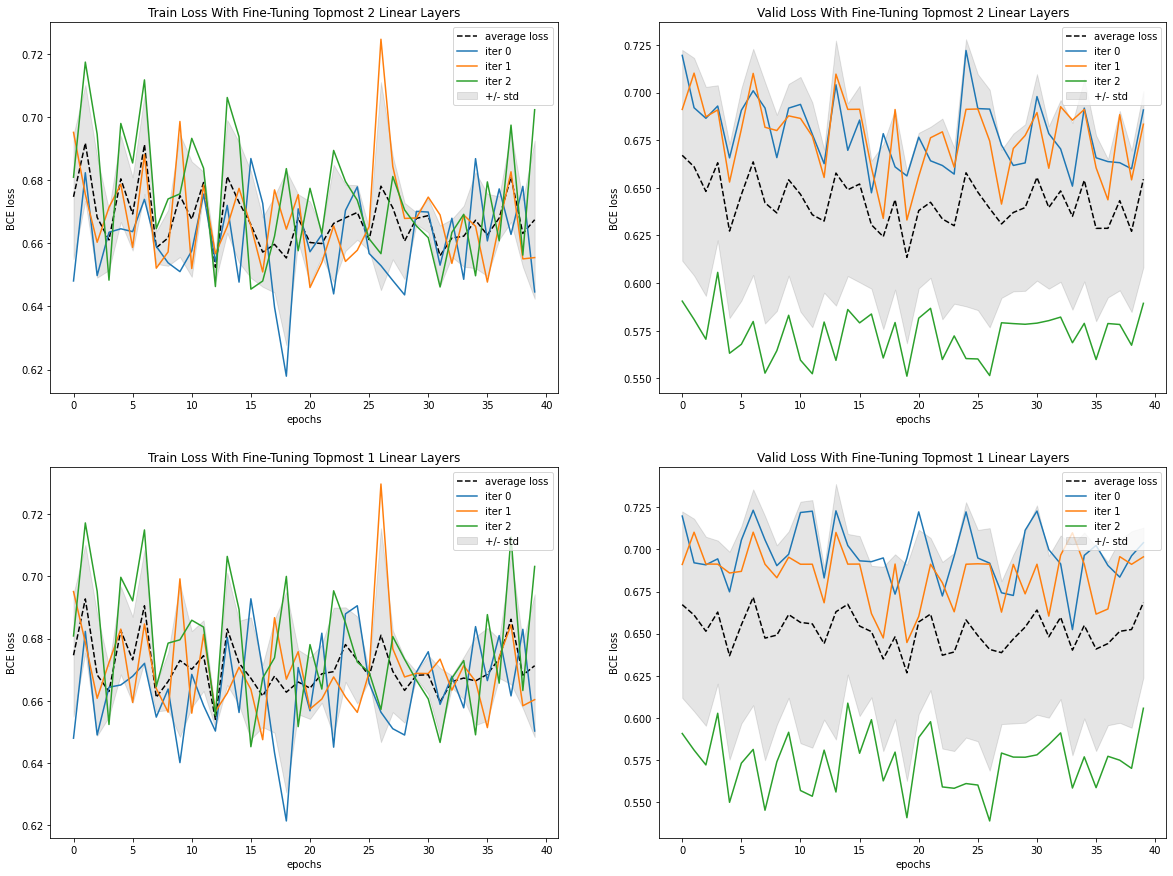

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 2, n_target_samples, loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 2, n_target_samples, loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 1, n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 1, n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

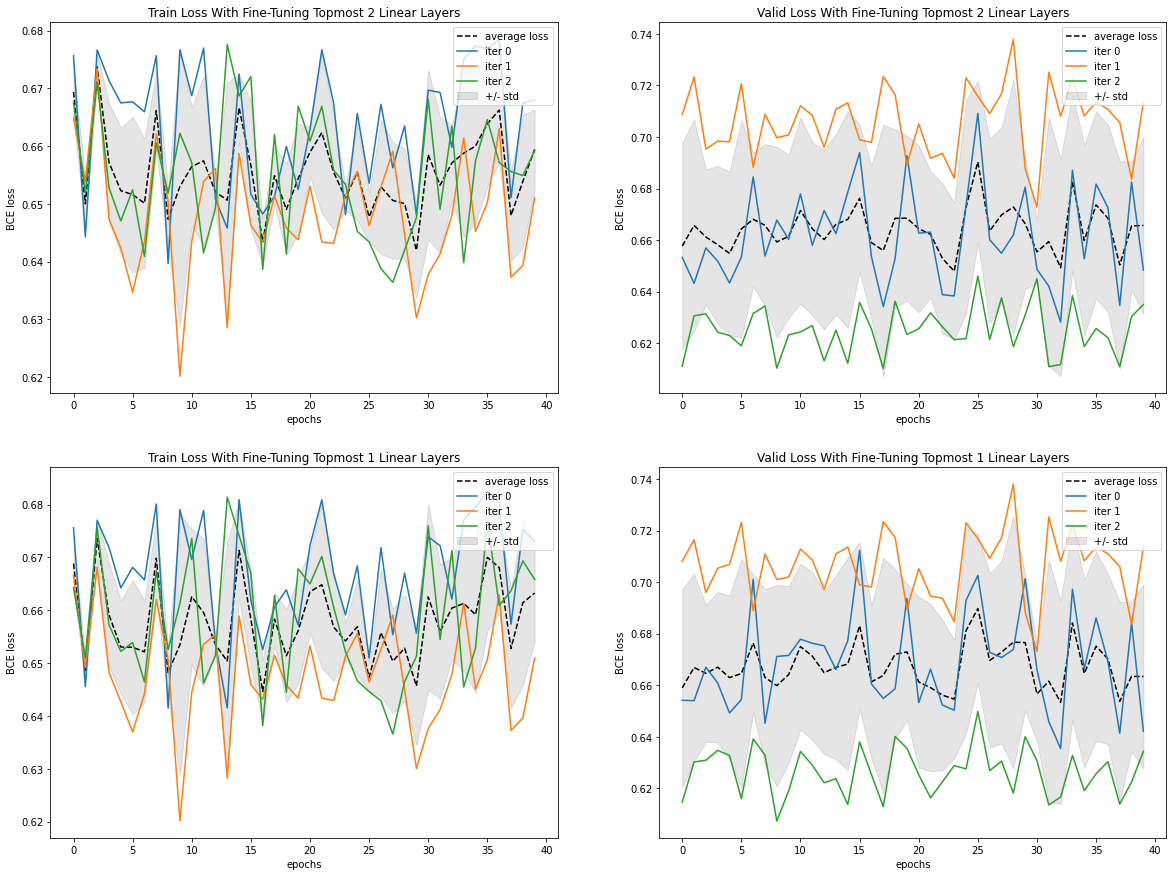

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 2, n_target_samples, loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 2, n_target_samples, loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 1, n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 1, n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

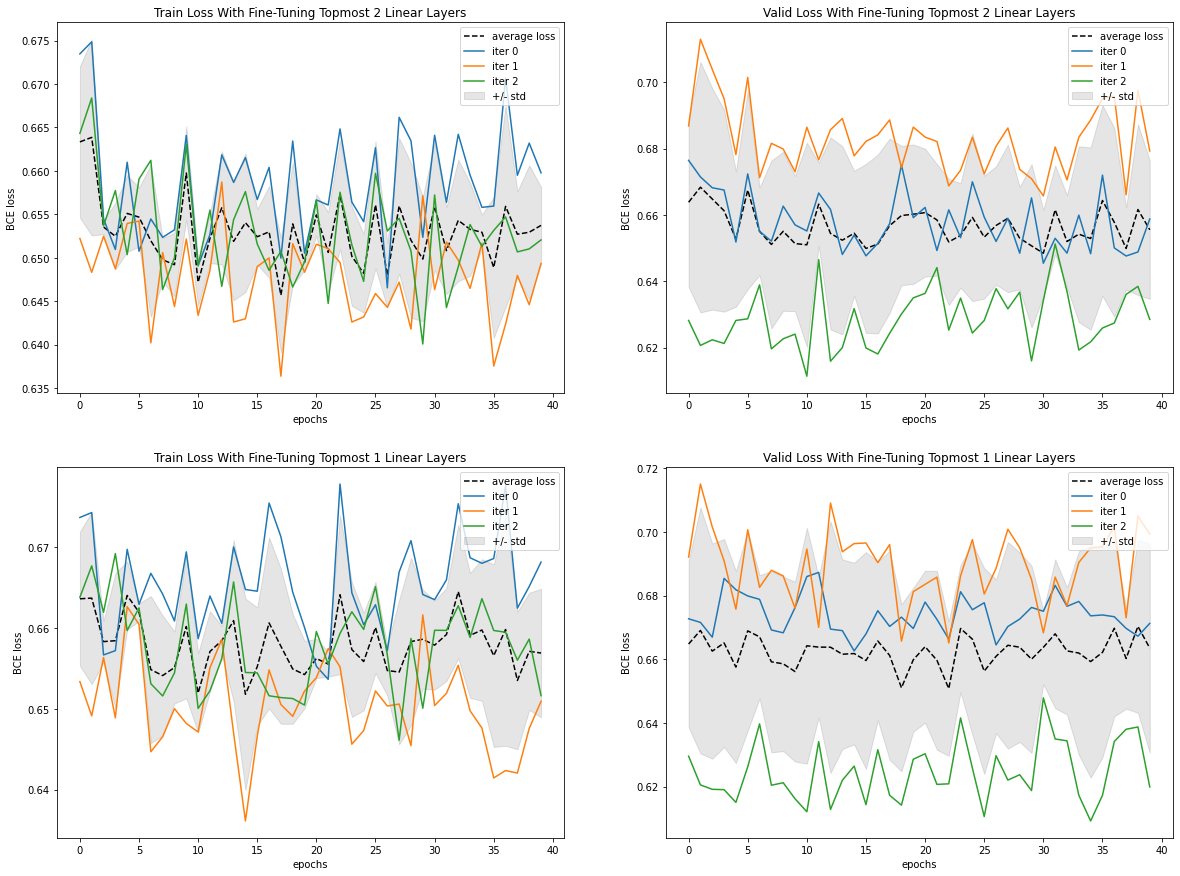

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 2, n_target_samples, loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 2, n_target_samples, loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 1, n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 1, n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

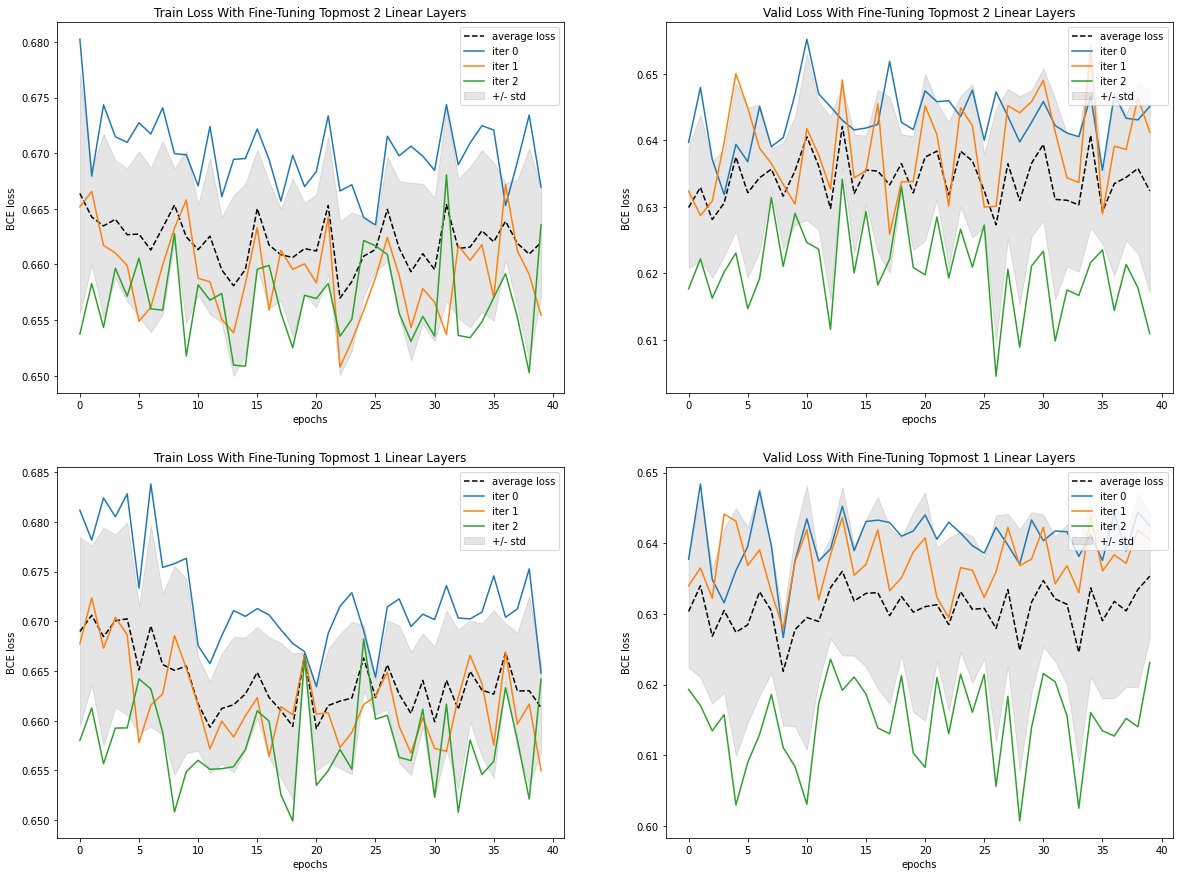

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 2, n_target_samples, loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 2, n_target_samples, loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 1, n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 1, n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [55]:
def plot_accuracies(df, num_topmost=1, n_target_samples=20, acc_type='train', ax=None):
   
    df = df[(df['num_topmost'] == num_topmost) & (df['n_target_samples'] == n_target_samples)].copy()
    subset_df = df[df['phase'] == 'target'].copy()
    key = f'{acc_type}_acc'
    acc = np.stack(subset_df.loc[:, key].values)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy with fine-tuning topmost {num_topmost} layers'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

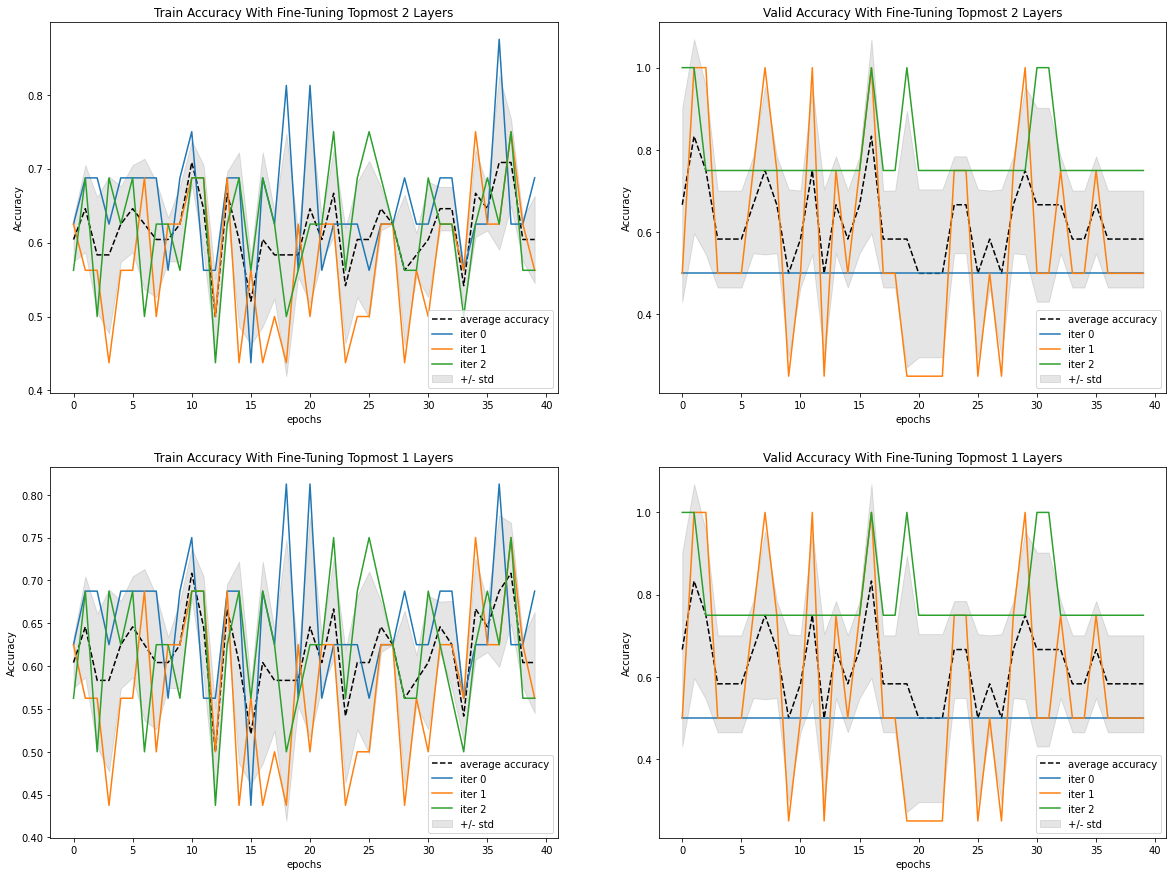

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 2, n_target_samples, acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 2, n_target_samples, acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

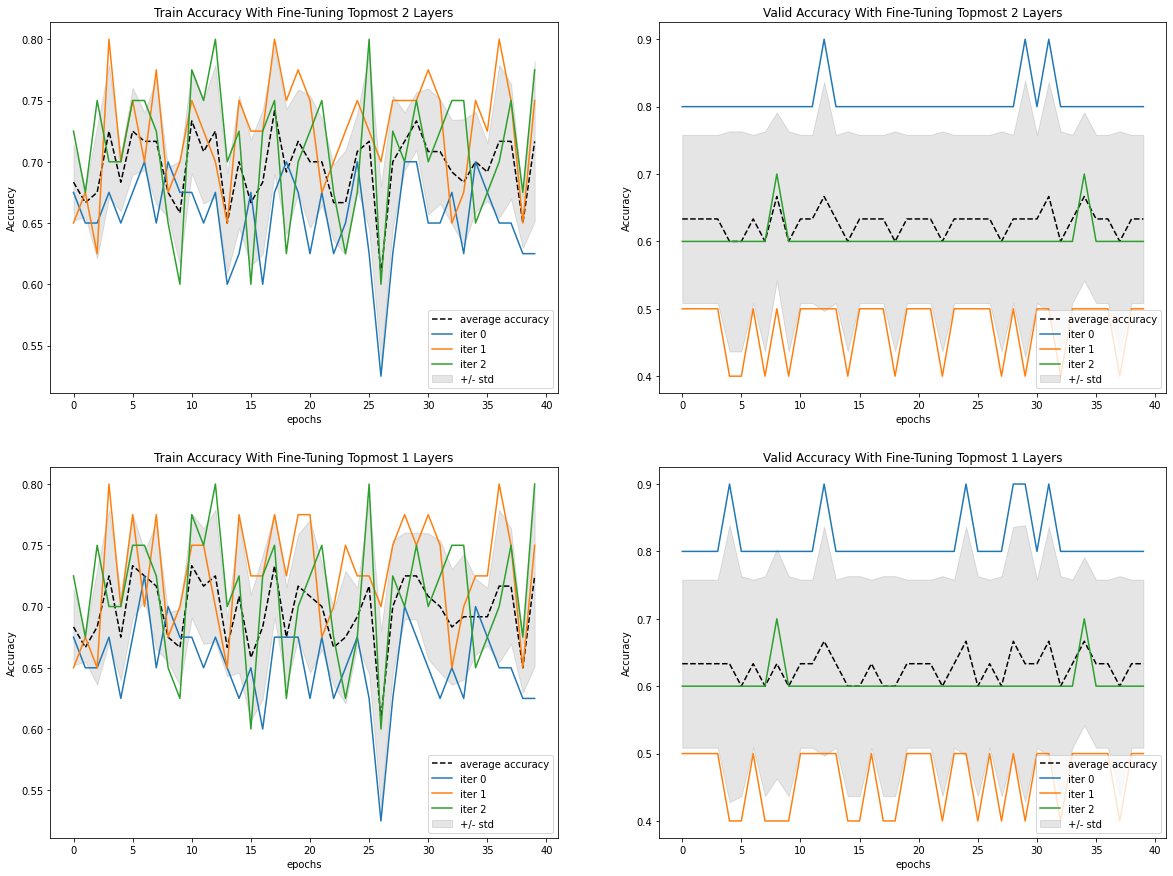

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 2, n_target_samples, acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 2, n_target_samples, acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

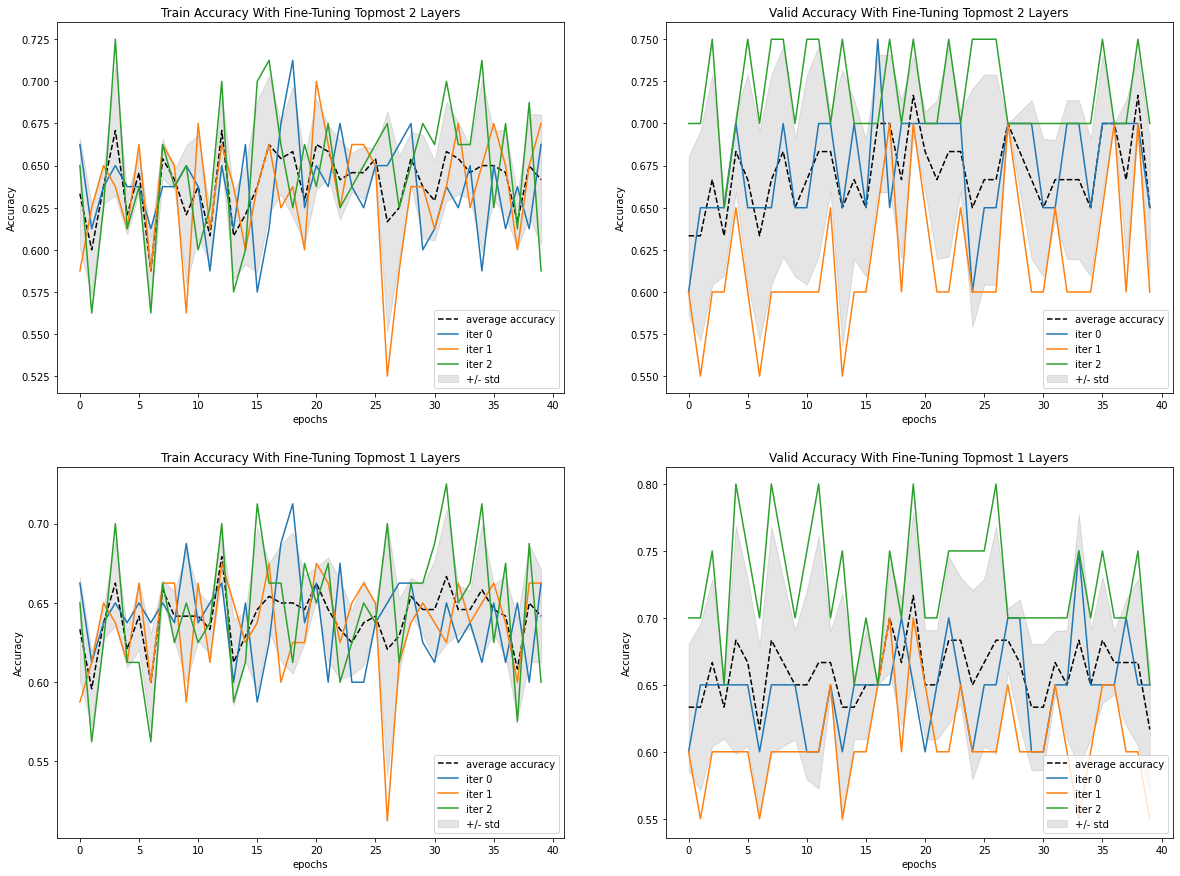

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 2, n_target_samples, acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 2, n_target_samples, acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

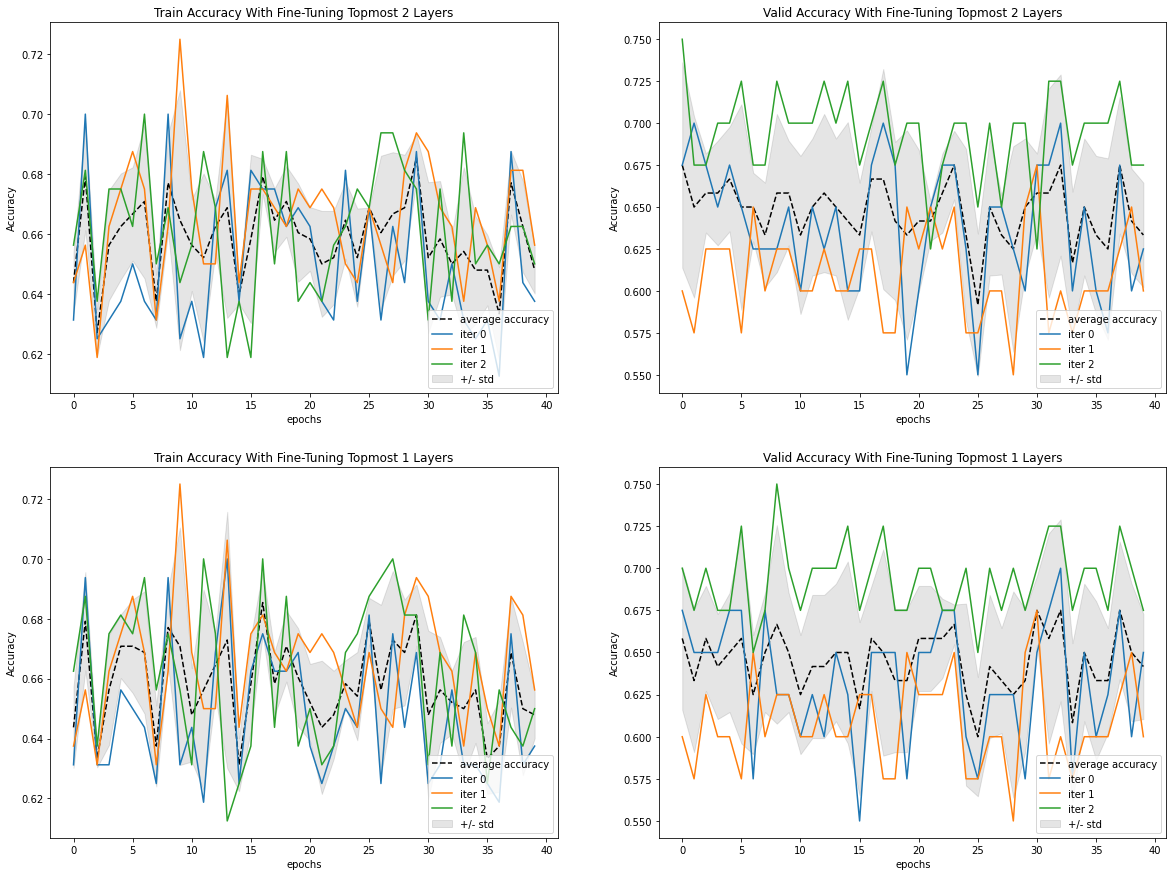

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 2, n_target_samples, acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 2, n_target_samples, acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

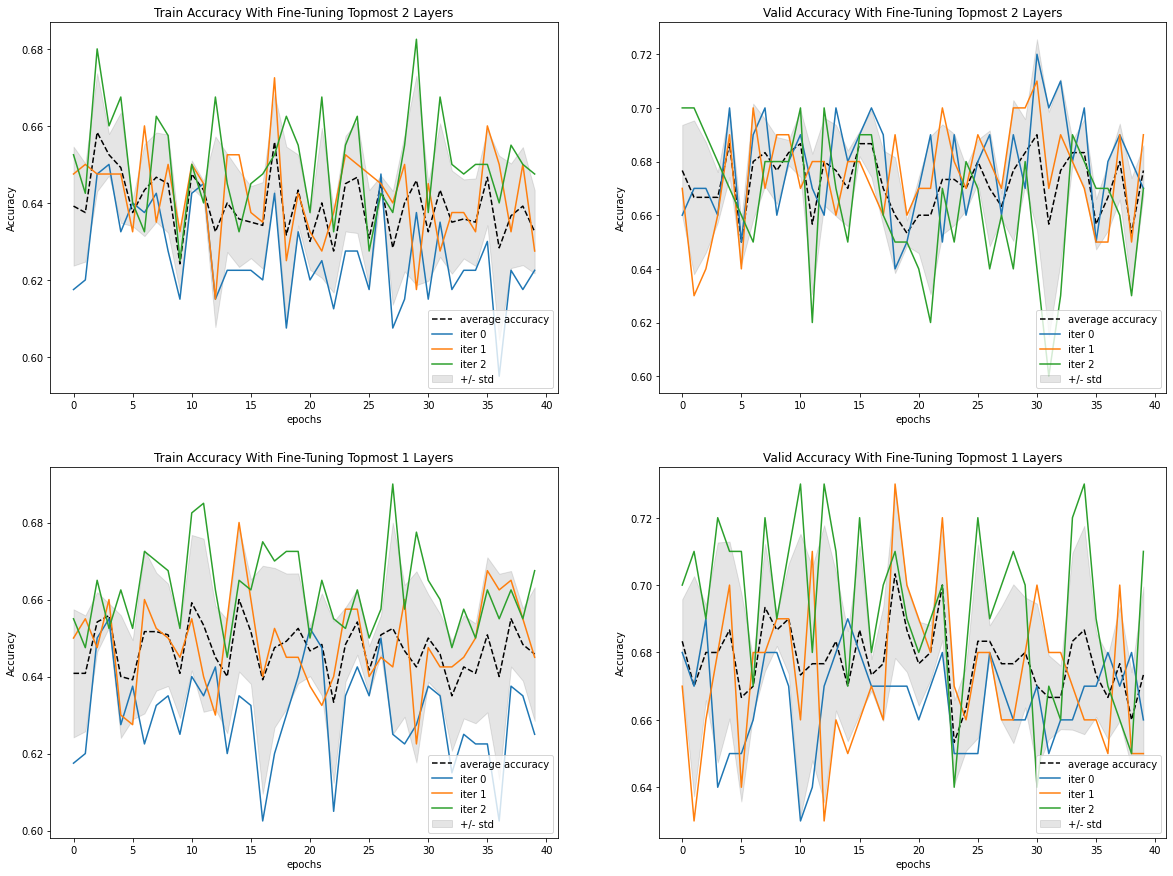

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 2, n_target_samples, acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 2, n_target_samples, acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

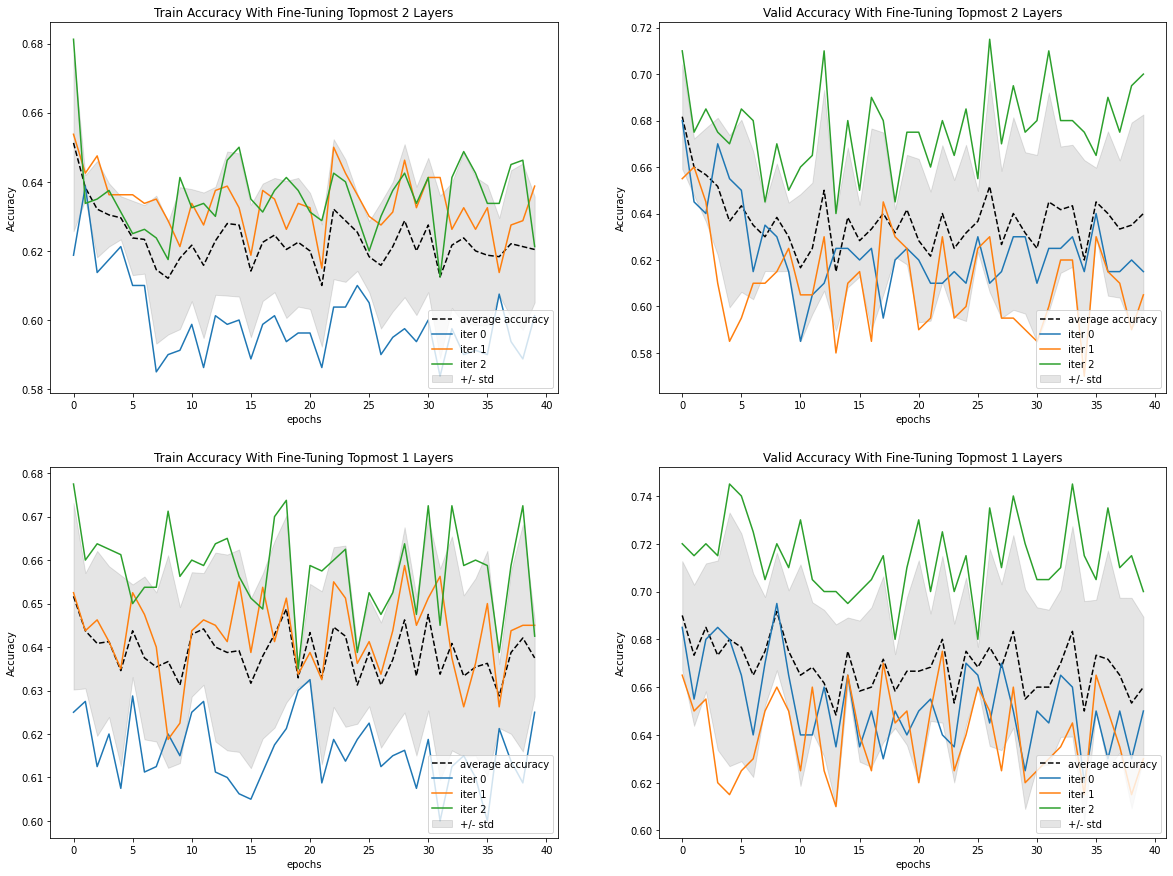

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 2, n_target_samples, acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 2, n_target_samples, acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 1, n_target_samples, acc_type='valid', ax=ax[1, 1])